# Overview

In this notebook we compute equivalent kernels for different basis functions, and use them to fit sinusoidal data.
The example is based on Bishop's "Pattern Recognition and Machine Learning" book, section 3.3.3.

In [143]:
%pylab inline
plt.style.use("default")
from matplotlib.gridspec import GridSpec

Populating the interactive namespace from numpy and matplotlib


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [149]:
def get_basis(which_basis = "gauss", n = 10, x_rng = [-1,1], **kwargs):
    if which_basis == "gauss":
        mu = np.linspace(x_rng[0], x_rng[1], n)
        sigma = ((x_rng[1] - x_rng[0]) / n) if "sigma" not in kwargs else kwargs["sigma"]
        basis = [lambda x: (0*x + 1)] + [lambda x, mu = mu[i], sigma = sigma: np.exp(-0.5 * ((x - mu) / sigma) ** 2) for i in range(n)]
    elif which_basis == "poly":
        basis = [lambda x, i = i: x ** i for i in range(n+1)]
    elif which_basis == "sigmoid":
        mu = np.linspace(x_rng[0], x_rng[1], n)
        sigma = ((x_rng[1] - x_rng[0]) / (2*n)) if "sigma" not in kwargs else kwargs["sigma"]
        basis = [lambda x: (0*x + 1)] + [lambda x, mu = mu[i], sigma = sigma: 1 / (1 + np.exp(-((x - mu) / sigma))) for i in range(n)]
    else:
        raise ValueError(f"Unknown basis function {which_basis}.")

    return basis

def plot_basis(basis, x_rng = [-1,1], n_points = 1000):
    x = np.linspace(x_rng[0], x_rng[1], n_points)
    for f in basis:
        plot(x, f(x))

def get_data(n_points = 100, x_rng = [-1,1], noise = 0.1):
    x = sort(np.random.uniform(x_rng[0], x_rng[1], n_points))
    y = np.sin(2 * np.pi * x) + np.random.normal(0, noise, n_points)
    return x, y


Text(0.5, 1.0, 'gauss basis functions')

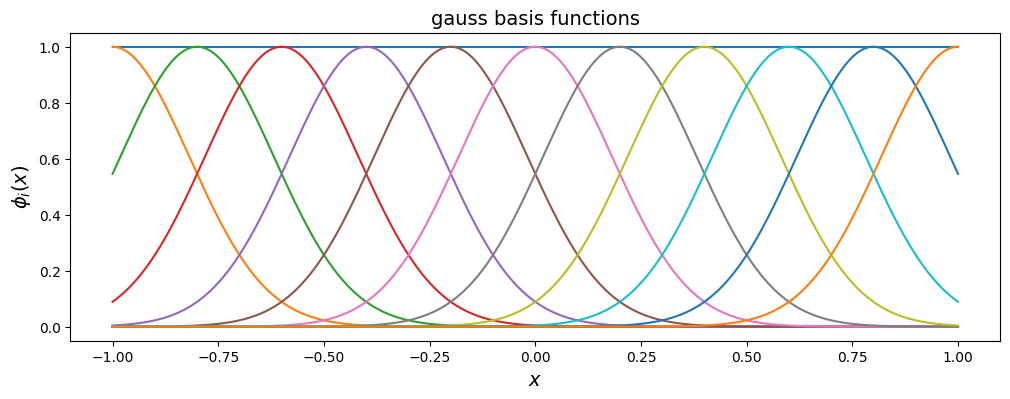

In [176]:
n_basis = 11
which_basis = "gauss"
basis = get_basis(which_basis, n_basis)
figure(figsize=(12, 4))
plot_basis(basis)
xlabel("$x$", fontsize=14)
ylabel("$\phi_i(x)$", fontsize=14)
title(f"{which_basis} basis functions", fontsize=14)

Text(0.5, 1.0, 'Data')

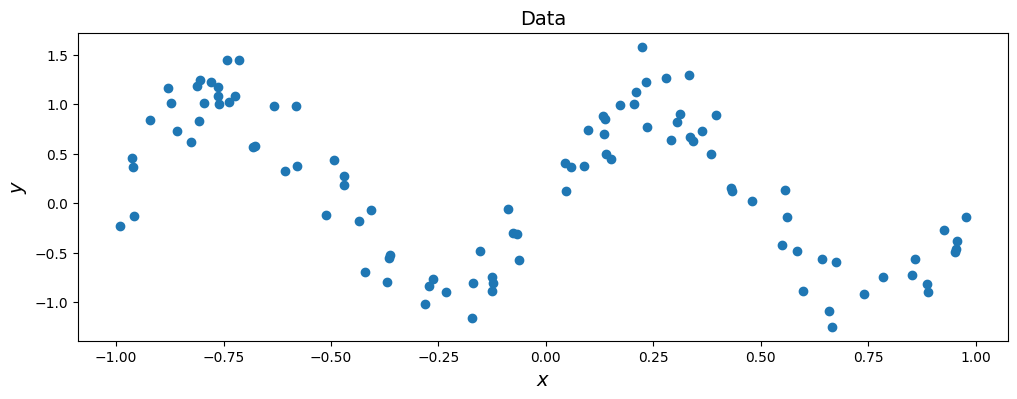

In [177]:
random.seed(0)
noise_sd = 0.25
x_data, y = get_data(noise = noise_sd)
figure(figsize=(12, 4))
plot(x_data, y, "o")
xlabel("$x$", fontsize=14)
ylabel("$y$", fontsize=14)
title("Data", fontsize=14)

Text(0.5, 1.0, 'Design matrix')

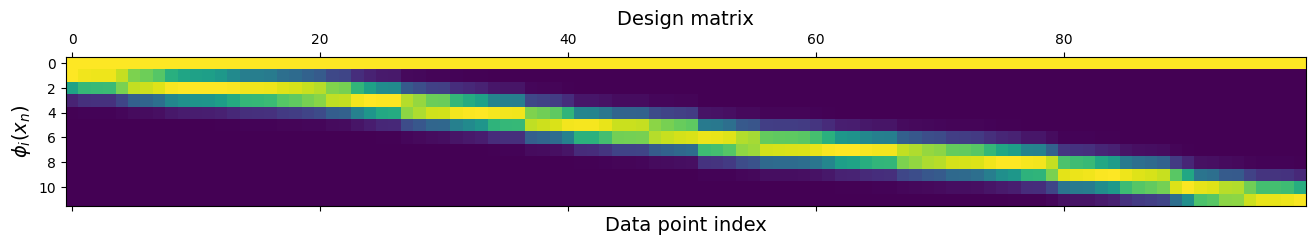

In [178]:
Phi = np.array([[f(x_i) for f in basis] for x_i in x_data])
n_data, n_basis = Phi.shape
matshow(Phi.T)
xlabel("Data point index", fontsize=14)
ylabel("$\phi_i(x_n)$", fontsize=14)
title("Design matrix", fontsize=14)

# Compute the feature precision and covariance

Text(0.5, 1.0, '$S = (\\alpha I + \\beta \\Phi^T \\Phi)^{-1}$')

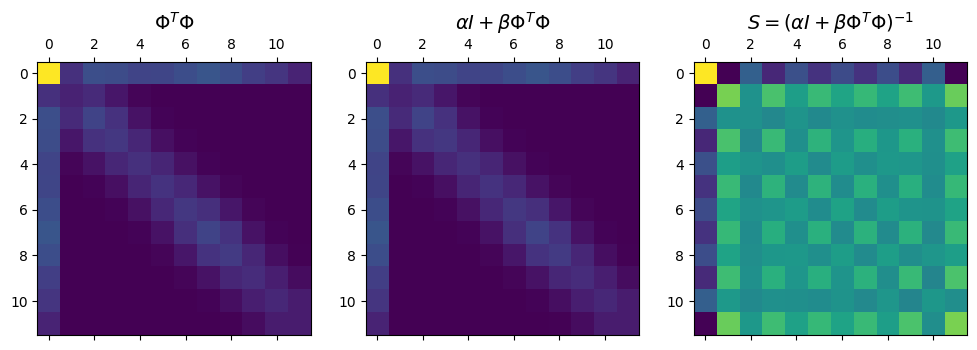

In [190]:
alpha = 0.1
beta  = 1/noise_sd**2
I     = np.eye(n_basis)
Prec  = alpha * I + beta * Phi.T @ Phi
S     = np.linalg.inv(Prec)
figure(figsize=(12, 4))
subplot(1,3,1).matshow(Phi.T @ Phi); title("$\Phi^T \Phi$", fontsize=14)
subplot(1,3,2).matshow(alpha *I + beta * Phi.T @ Phi); title("$\\alpha I + \\beta \Phi^T \Phi$", fontsize=14)
subplot(1,3,3).matshow(S); title("$S = (\\alpha I + \\beta \Phi^T \Phi)^{-1}$", fontsize=14)

# Compute the equivalent kernel

In [221]:
x_ker = np.linspace(-1, 1, 201)
phi_x = np.array([[f(x_i) for f in basis] for x_i in x_ker])
K = np.zeros((len(x_ker), len(x_ker)))
for i, phi_xi in enumerate(phi_x):
    for j, phi_xj in enumerate(phi_x):
        K[i,j] = beta * phi_xi @ S @ phi_xj
        

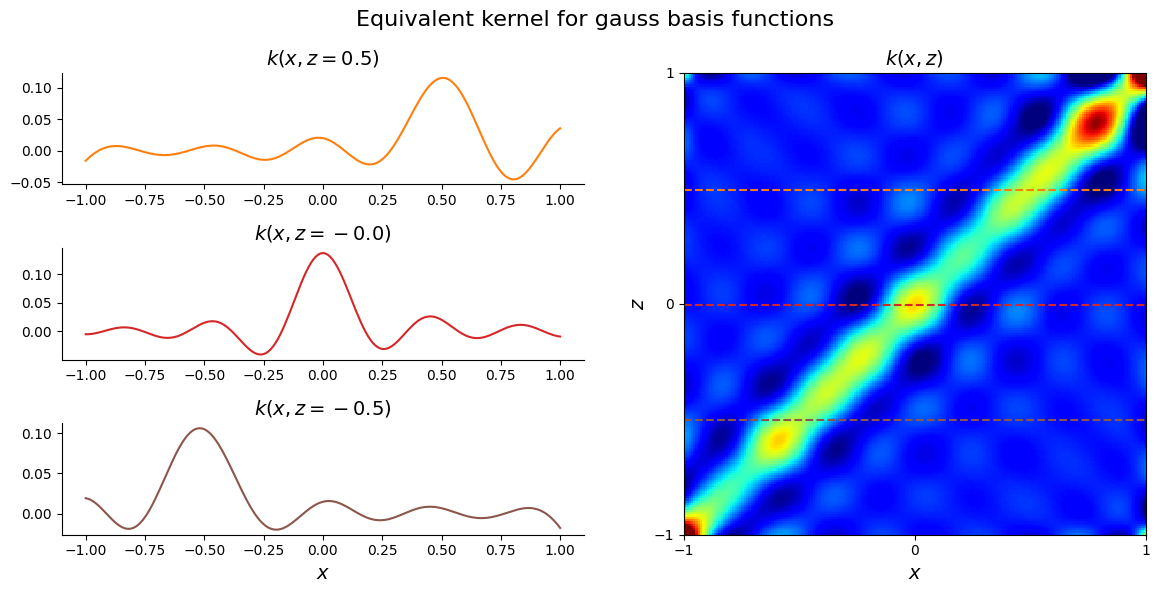

In [222]:
figure(figsize=(12, 6))
gs = GridSpec(3, 2)
n_K = K.shape[0]
for i in range(3):
    ax = subplot(gs[i,0]);
    ax.plot(x_ker, K[:,n_K//4 *(4-i-1)], color=f"C{2*i+1}");
    # Turn the top and right spines off
    [ax.spines[spine].set_visible(False) for spine in ["top","right"]]
    i == 2 and ax.set_xlabel("$x$", fontsize=14)
    z = n_K//4 *(4-i-1)/n_K*2 - 1
    ax.set_title("$k(x," + f"{z=:.1f}" +")$", fontsize=14)

subplot(gs[:,1]);
matshow(K, cmap="jet", fignum=False, clim=percentile(K, [1, 99.9]), origin="lower",extent=(-1, 1, -1, 1))
# Put the xticks at the bottom
gca().xaxis.tick_bottom()
xlabel("$x$", fontsize=14)
ylabel("$z$", fontsize=14)
title("$k(x,z)$", fontsize=14)

for i in range(3):
    axhline(n_K//4 *(4-i-1)/n_K*2 - 1, color=f"C{2*i+1}", ls="--")

suptitle(f"Equivalent kernel for {which_basis} basis functions", fontsize=16)
tight_layout()

# Use the equivalent kernel to fit the data

In [223]:
x_fit = np.linspace(-1, 1, 100)
y_fit = 0*x_fit
phi_f = np.array([[f(xf_i) for f in basis] for xf_i in x_fit])
phi_d = np.array([[f(xd_i) for f in basis] for xd_i in x_data])
for i, xf_i in enumerate(x_fit):
    for j, xd_i in enumerate(x_data):
        kij = beta * phi_d[j] @ S @ phi_f[i]
        y_fit[i] += kij * y[j]

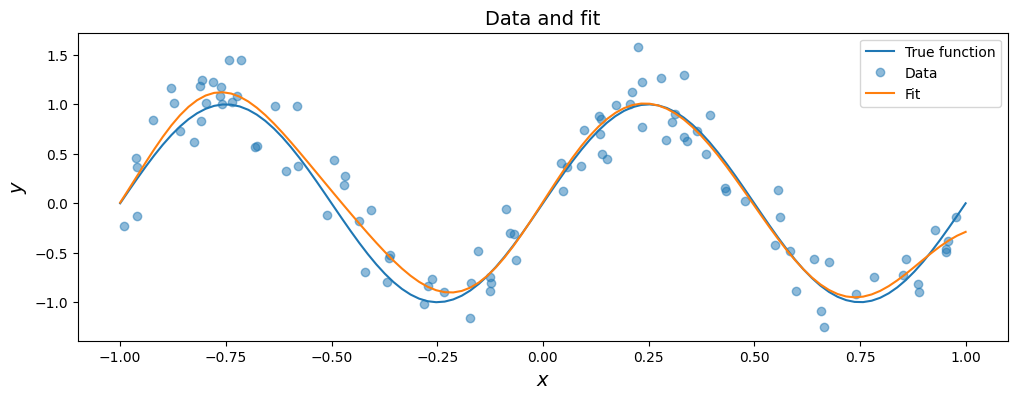

In [224]:
figure(figsize=(12, 4))
plot(x_fit, np.sin(2*np.pi*x_fit), label="True function")
plot(x_data, y, "o", color="C0", alpha=0.5, label="Data")
plot(x_fit, y_fit,label="Fit")
xlabel("$x$", fontsize=14)
ylabel("$y$", fontsize=14)
title("Data and fit", fontsize=14)
legend()